# Training set generation, and NN training

In [1]:
import sys
import os
import numpy as np
np.random.seed(42)

import tensorflow as tf
from tensorflow import keras
from bumps.initpop import lhs_init
import pandas as pd

import json
import refl1d
from refl1d.names import *

from matplotlib import pyplot as plt
import matplotlib.lines as mlines
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')


In [5]:
# Directory in which the code sits
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'ml-nr-two-layers')

# Data directory
data_dir = os.path.join(git_dir, 'data')

In [6]:
# Path to our test data
haynes = os.path.join(data_dir, 'haynes_off_off_v2.dat')

In [7]:
sys.path.append(git_dir)

import reflectivity_model_haynes
import importlib
importlib.reload(reflectivity_model_haynes)

<module 'reflectivity_model_haynes' from '/Users/m2d/git/ml-nr-two-layers/reflectivity_model_haynes.py'>

In [8]:
# Load some data to define the q axis
data_off = np.loadtxt(os.path.join(data_dir, "haynes_off_off_v2.dat")).T
q_ref = data_off[0]

# Create or load the training set

In [9]:
%%time
nval=50000
n_train = 1000000

reload = True

m = reflectivity_model_haynes.ReflectivityModels(q=q_ref)

if reload:
    q, train_data, train_pars = m.load(os.path.join(data_dir, 'training_data'))
    print(train_data.shape)
else: 
    print("Generating...")
    m.generate(n_train)
    print("Pre-processing...")
    train_pars, train_data = m.get_preprocessed_data()
    print("Saving...")
    m.save(os.path.join(data_dir, 'training_data'))

(1000000, 92)
CPU times: user 1.59 ms, sys: 365 ms, total: 366 ms
Wall time: 368 ms


# Plotting an example of pre-processed data

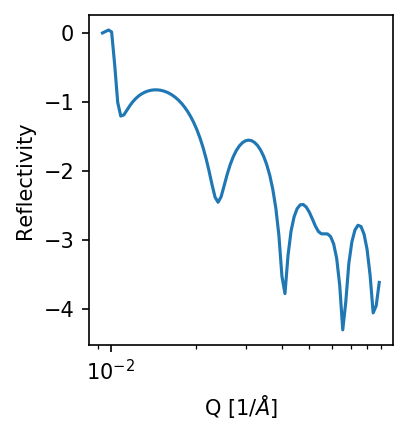

In [10]:
i=100

fig, axs = plt.subplots(1, 1, sharey=False, tight_layout=True, dpi=150, figsize=(5,3))

ax = plt.subplot(1, 2, 2)
plt.plot(m.q, train_data[i])
plt.xscale('log')
plt.xlabel('Q [$1/\AA$]')
plt.ylabel('Reflectivity')

plt.show()

# Defining our NN model

In [11]:
%%time
from tensorflow import keras

print("Input number of points: %g" % train_data.shape[1:])
   
activation='selu'
kernel_initializer='lecun_normal'

model = keras.models.Sequential([
keras.layers.Input(shape=train_data.shape[1:]),
keras.layers.Dense(300, activation=activation, kernel_initializer=kernel_initializer),
keras.layers.Dense(400, activation=activation, kernel_initializer=kernel_initializer),
keras.layers.Dense(400, activation=activation, kernel_initializer=kernel_initializer),
keras.layers.Dense(400, activation=activation, kernel_initializer=kernel_initializer),
keras.layers.Dense(100, activation=activation, kernel_initializer=kernel_initializer),
keras.layers.Dense(50, activation=activation, kernel_initializer=kernel_initializer),
keras.layers.Dense(train_pars.shape[1])])

# Good learning rate is 0.0005
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=0.0005))


Input number of points: 92
CPU times: user 68.6 ms, sys: 12.3 ms, total: 80.9 ms
Wall time: 74.3 ms


# Train

In [52]:
%%time
# Best results are with 20 epochs with a learning rate of 0.0005, which avoids over-fitting and minimizes loss.
nval=10000
history = model.fit(train_data[:-nval], train_pars[:-nval], epochs=20, batch_size=256, 
                   validation_data=(train_data[n_train-nval:], train_pars[n_train-nval:]))


Epoch 1/20
3868/3868 [==============================] - 22s 6ms/step - loss: 0.1981 - val_loss: 0.1470
Epoch 2/20
3868/3868 [==============================] - 22s 6ms/step - loss: 0.1252 - val_loss: 0.1145
Epoch 3/20
3868/3868 [==============================] - 23s 6ms/step - loss: 0.0963 - val_loss: 0.0851
Epoch 4/20
3868/3868 [==============================] - 24s 6ms/step - loss: 0.0798 - val_loss: 0.0725
Epoch 5/20
3868/3868 [==============================] - 28s 7ms/step - loss: 0.0695 - val_loss: 0.0659
Epoch 6/20
3868/3868 [==============================] - 28s 7ms/step - loss: 0.0630 - val_loss: 0.0593
Epoch 7/20
3868/3868 [==============================] - 28s 7ms/step - loss: 0.0588 - val_loss: 0.0615
Epoch 8/20
3868/3868 [==============================] - 27s 7ms/step - loss: 0.0552 - val_loss: 0.0545
Epoch 9/20
3868/3868 [==============================] - 25s 6ms/step - loss: 0.0527 - val_loss: 0.0583
Epoch 10/20
3868/3868 [==============================] - 23s 6ms/step - l

In [12]:
# Save the trained model
reflectivity_model_haynes.save_model(model, 'haynes', data_dir=os.path.join(data_dir, 'training_data'))
json.dump(history.history, open(os.path.join(data_dir, "training_data", "haynes_history.json"), 'w'))

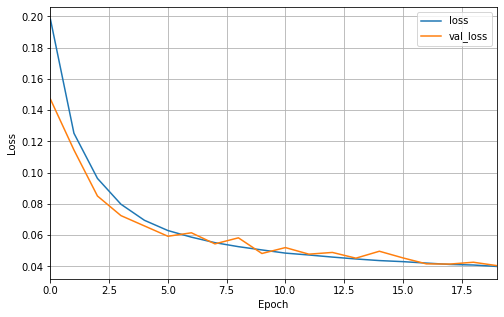

In [53]:
pd.DataFrame(history.history).plot(figsize=(8 ,5))
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('linear')
plt.show() 

# Trying out the trained model

{'sld': 4.122518933080718, 'isld': 0, 'thickness': 202.1463131602966, 'roughness': 6.997133659596667, 'name': 'oxide'}
{'sld': 4.081109046936035, 'isld': 0, 'thickness': 209.50503540039062, 'roughness': 3.4256458282470703, 'name': 'oxide'}


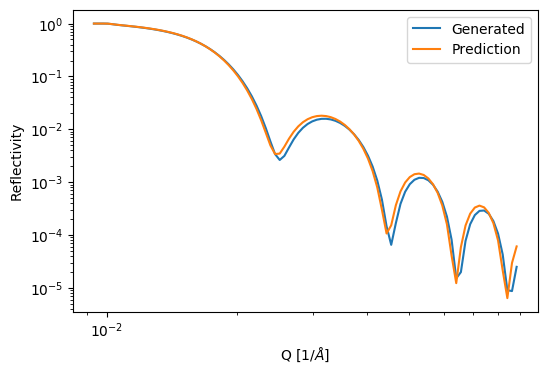

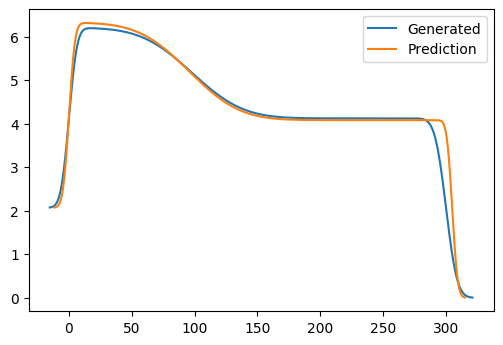

In [54]:
validation_data = train_data[n_train-nval:]
validation_pars = train_pars[n_train-nval:]
#validation_data = train_data
#validation_pars = train_pars


i_test = 20

# True model
model_pars = m.to_model_parameters(validation_pars)
_desc = m.get_model_description(model_pars[i_test])
iq_, z_, sld_ = reflectivity_model_haynes.calculate_reflectivity(m.q, _desc)
print(_desc['layers'][2])

# Prediction
preds = model.predict(validation_data)
model_pars = m.to_model_parameters(preds)
_desc = m.get_model_description(model_pars[i_test])
iq_pred, z_pred, sld_pred = reflectivity_model_haynes.calculate_reflectivity(m.q, _desc)
print(_desc['layers'][2])

fig = plt.figure(dpi=100)
plt.loglog(m.q, iq_, label="Generated")
plt.errorbar(m.q, iq_pred, label='Prediction')
plt.gca().legend()
plt.xlabel('Q [$1/\AA$]')
plt.ylabel('Reflectivity')
plt.show()

fig = plt.figure(dpi=100)
plt.plot(z_, sld_, label="Generated")
plt.plot(z_pred, sld_pred, label="Prediction")
plt.gca().legend()


Text(0.5, 0, 'true')

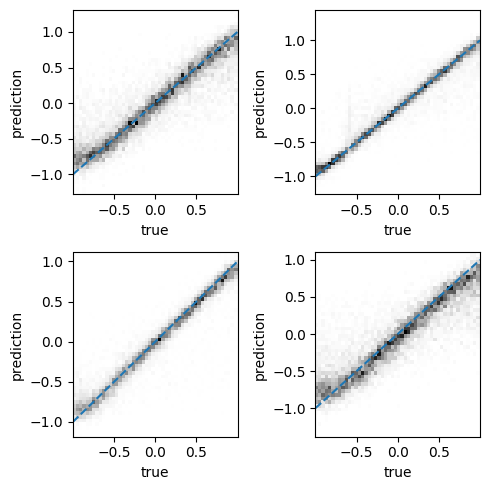

In [55]:

fig, axs = plt.subplots(2, 2, sharey=False, tight_layout=True, dpi=100, figsize=(5,5))

ax = plt.subplot(2, 2, 1)
ax.hist2d(validation_pars[:,0], preds[:,0], bins=50, cmap="Greys")
l = mlines.Line2D([-1, 1], [-1, 1], linestyle='--')
ax.add_line(l)
plt.ylabel('prediction')
#ax.set_title('Inter-layer roughness [$\AA$]')
plt.xlabel('true')

ax = plt.subplot(2, 2, 2)
ax.hist2d(validation_pars[:,1], preds[:,1], bins=50, cmap="Greys")
l = mlines.Line2D([-1, 1], [-1, 1], linestyle='--')
ax.add_line(l)
plt.ylabel('prediction')
#ax.set_title('SLD [$10^{-6}/\AA^2$]')
plt.xlabel('true')

ax = plt.subplot(2, 2, 3)
ax.hist2d(validation_pars[:,2], preds[:,2], bins=50, cmap="Greys")
l = mlines.Line2D([-1, 1], [-1, 1], linestyle='--')
ax.add_line(l)
plt.ylabel('prediction')
#ax.set_title('Thickness [$\AA$]')
plt.xlabel('true')

ax = plt.subplot(2, 2, 4)
ax.hist2d(validation_pars[:,3], preds[:,3], bins=50, cmap="Greys")
l = mlines.Line2D([-1, 1], [-1, 1], linestyle='--')
ax.add_line(l)
plt.ylabel('prediction')
#ax.set_title('Surface roughness [$\AA$]')
plt.xlabel('true')

